In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.metrics as metrics
from pingouin import ancova
from diagnostic_plots import plot
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from model_selection import exhaustivesearch_selectionmodel

%matplotlib inline
sns.set_theme(palette='colorblind', style='darkgrid')

In [2]:
df = pd.read_csv('abalone.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [3]:
df['Sex'] = pd.Categorical(df['Sex'])

# Part I: EDA and Model validation

### Question 1: Write a mathematical formula modelling the several assumptions in the above description. Describe what kind of statistical techniques you are going to use to study these hypothesis (confidence intervals, test,... )

The goal is to predict the age of an Abalone through the number of rings based on the height measurement. Biologists believe that this can be achieved by modelling a simple linear relationship between number of rings and height. Based on the aforementioned assumptions, the mathematical formula for our simple linear regression model is the following:

$$
Y_i=  \text{$\beta_0 + \beta_1 \cdot X_i$ + $\varepsilon_i$}
$$
where :
$$
Y_i:\textit{The number of rings of the abalone i}
$$$$
X_i:\textit{The height of the abalone i, with X being full rank}
$$$$
\beta_0 \textit{ is the intercept and } \beta_1 \textit{ is the slope of the linear regression model}
$$$$
\varepsilon_i: \textit{The i-th error term such that }\varepsilon_i\sim \mathcal{N(0,\sigma^2)}\textit{, }\sigma^2\textit{ being constant (homoscedasticity)}
$$

The statistical techniques that will be used to test these hypothesis are:
* Confidence Intervals for $\beta_0$ and $\beta_1$
* Residual Analysis (Gaussian Distribution and Homoscedasticity)
* Tests (t-tests, ANOVA, ANCOVA)

### Question 2: Find summary measures of each variables (mean, variance, range, etc). Examine the variables individually (univariate). Graphically display each. Describe what you see.

In [4]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


* We notice that the minimum height is 0, which must be an error. 
* We can also see that the data is quite evenly distributed between the three factor levels of male, female and infant.
* Finally, we see that there are four different measures of weight i.e. Whole_weight, Shucked_weight, Viscera_weight and Shell.weight. Whole_weight is a linear function of other weight predictors with unknown mass of water/blood lost from shucking process.

##### Response variable
The response variable Rings is included in the dataset. It was measured as the number of rings observed after cutting and examining an abalone. Although it does not denote the age of a given abalone directly, it determines it more-or-less perfectly. The age of an abalone equals Rings + (1.5). Since this relationship holds reliably, Rings will be considered as the response variable.

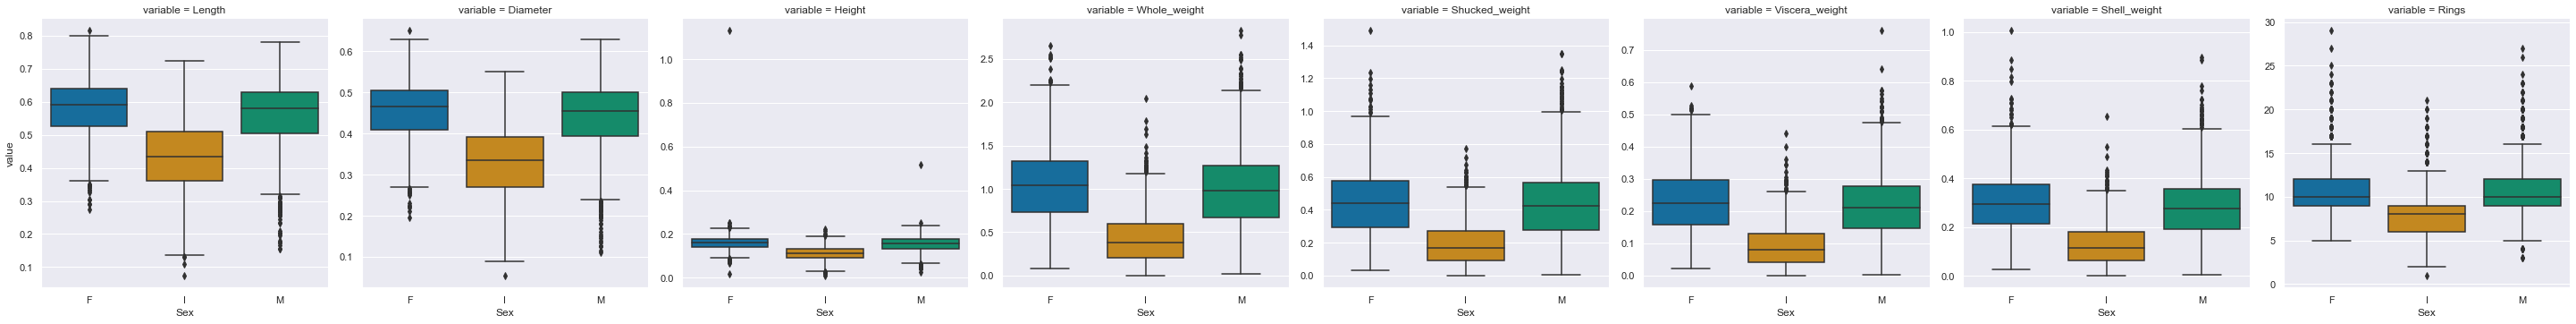

In [5]:
# Removing the rows in which height is equal to 0
df = df.loc[df['Height'] != 0.0]

# Plotting boxplots to have a better visualisation of eventual outliers
df_melted = df.melt('Sex')
sns.catplot(x='Sex', y='value', kind='box', data=df_melted, col='variable', sharey=False);

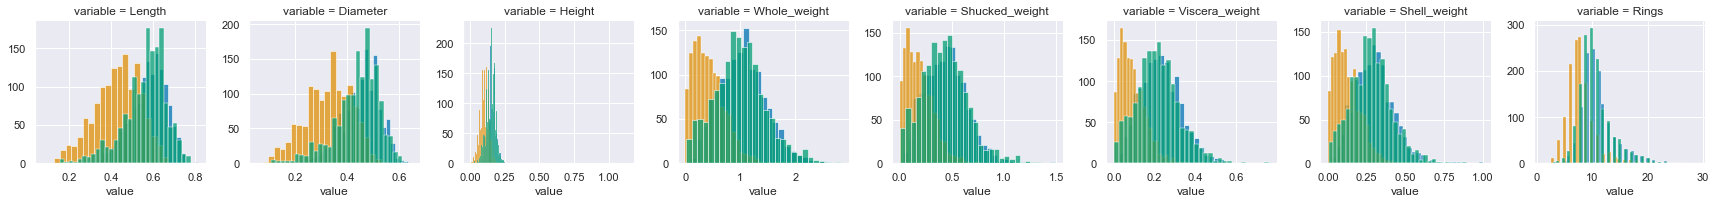

In [6]:
grid = sns.axisgrid.FacetGrid(df_melted, hue='Sex', col='variable', sharey=False, sharex=False)
grid.map(sns.histplot, 'value');

* We notice that the features are skewed and not Normally distributed (we could have guessed it by the fact that if they were, we would have Mean = Median). But they are still close to Normality.
* We notice that 'Length' and 'Diameter' have extremely similar histograms. We observe that as well for the Weight features. This may suggest multicollinearity.
* Most of the abalones' rings are between 5 and 15.

### Question 3: Generate a labeled scatterplot of the data. Describe interesting features trends. Does it agree with the biologists’ hypothesis?

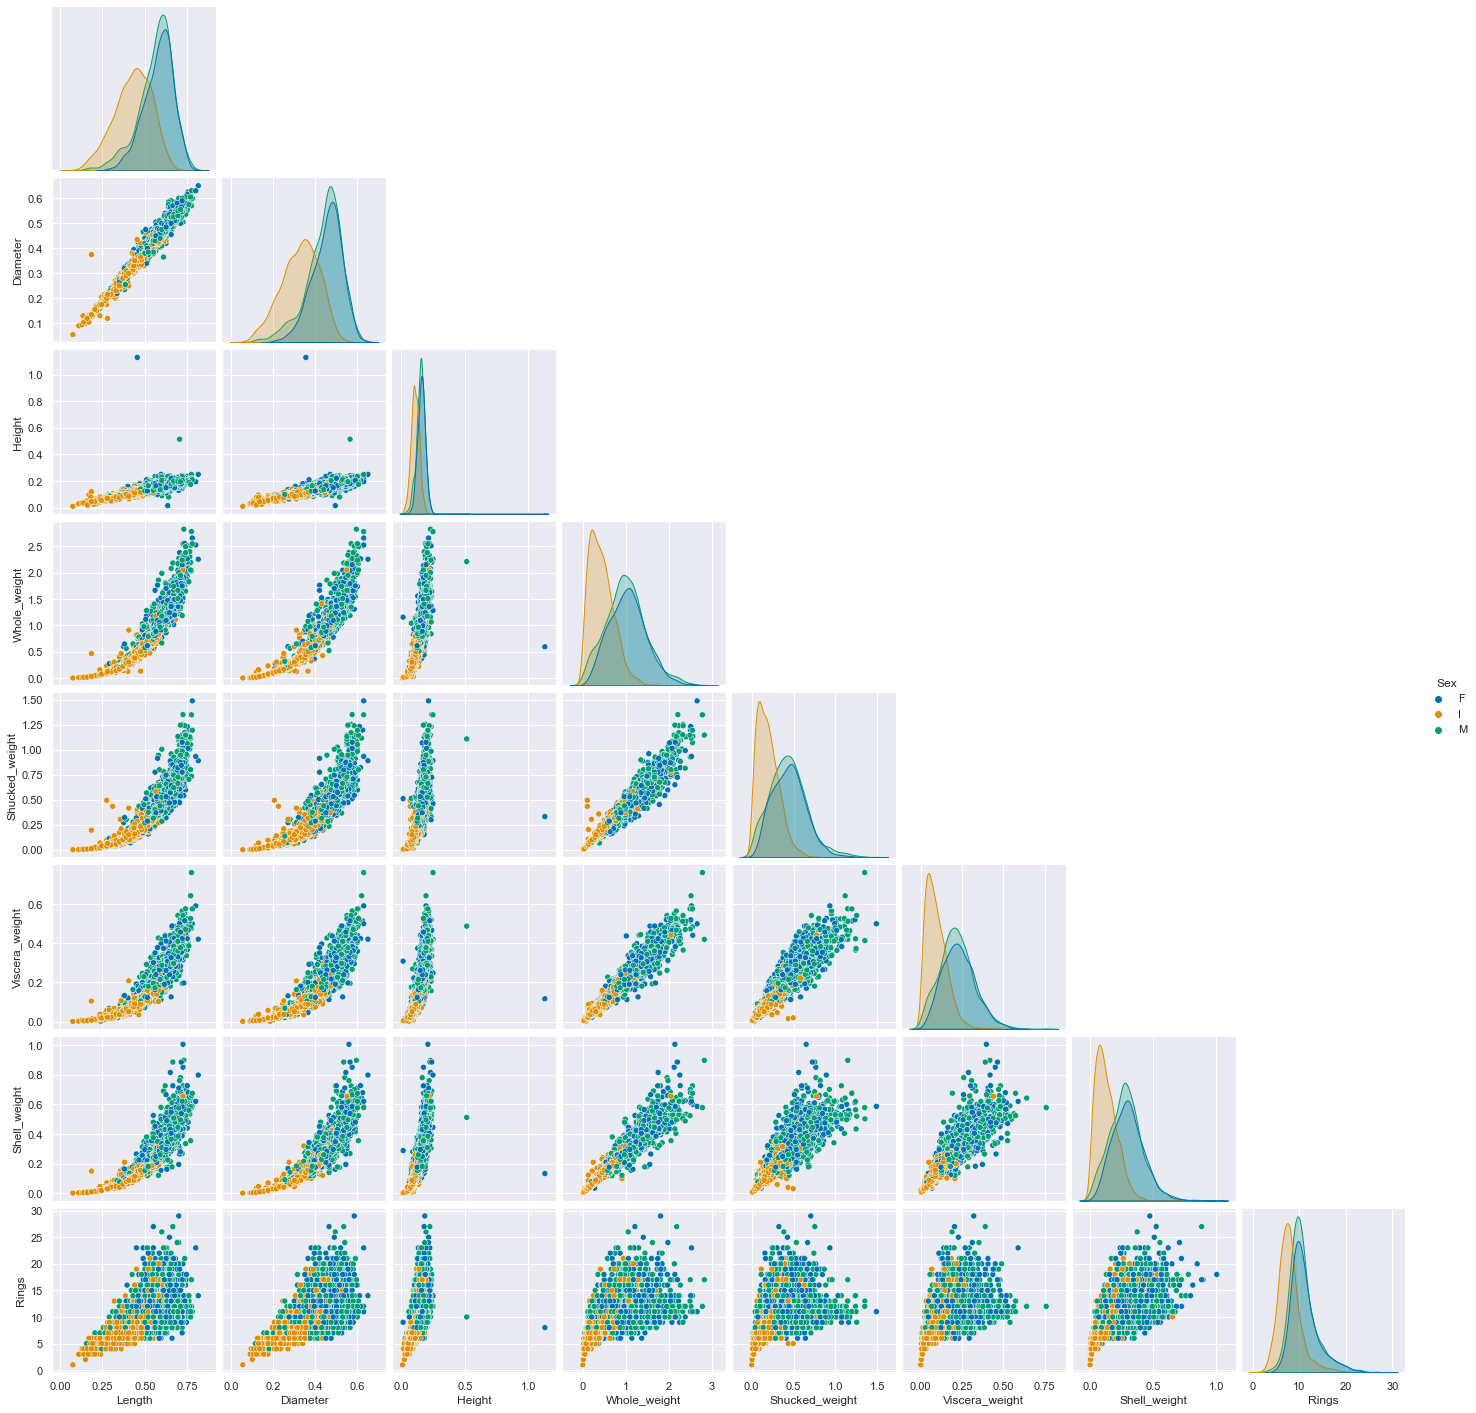

In [7]:
sns.pairplot(df, hue='Sex', corner=True);

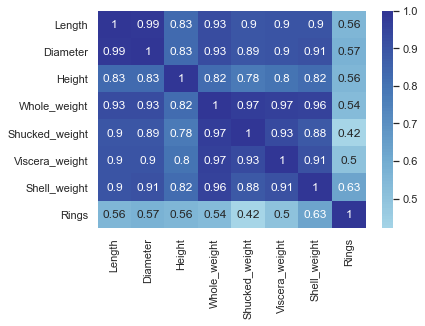

In [8]:
corr = df.corr()
sns.heatmap(corr, center=0, annot=True, cmap='RdYlBu');

* The first thing we notice is the high correlation in data. There seems to be high multicollinearity between the predictors. For example correlation between Diameter and Length is extremely high (0.99).
* Similarly Whole_weight seems to be highly correlated with other weight predictors and is the sum of Shucked_weight, Viscera_weight and Shell_weight.
* We notice that the number of rings increases with the height. This relationship seems to be linear, which seems to agree with the biologists' hypothesis.
* We also notice that the distributions of predictor Sex with factor level value of female and male are very similar with respect to all other predictors.
* The shape of distribution is also significantly similar for factor levels of female and male. We could think about redefining this feature to define gender as infant vs non-infant (where non-infant = female and male both).

In [9]:
# We update the abalone dataset to create a new variable named Infant which will have values based on
# original value from Sex variable. It will have a value of I when Sex variable is Infant and NI otherwise.
df['Infant'] = df.apply(lambda x: 'I' if x['Sex'] == 'I' else 'NI', axis=1)
df['Infant'] = pd.Categorical(df['Infant'])

### Question 4: Fit a simple linear regression to the data predicting number of rings using height of the abalones.

In [10]:
np.random.seed(25)
#Splitting dataset in train and test using 70/30 method
indexes = np.random.choice(len(df), np.int(len(df)*0.3), replace=False)
df_test = df.iloc[indexes]
df_train = df.loc[~(df.index.isin(indexes))]

In [11]:
model_simple1 = smf.ols('Rings~Height', data=df_train).fit()
print(model_simple1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     1697.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          6.92e-293
Time:                        18:58:29   Log-Likelihood:                -6923.0
No. Observations:                2923   AIC:                         1.385e+04
Df Residuals:                    2921   BIC:                         1.386e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8654      0.178     16.064      0.0

### Question 5: Generate a labeled scatterplot that displays the data and the estimated regression function line. Describe the line’s fit.

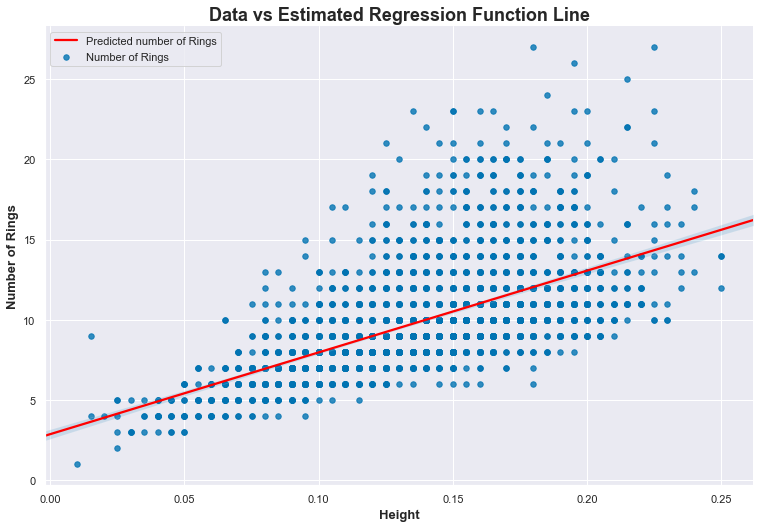

In [12]:
g = sns.lmplot(x='Height', y='Rings', data=df_train, aspect=1.5, height=7, truncate=False, scatter_kws={'s': 30})
regline = g.ax.get_lines()[0]
regline.set_color('red')
plt.xlabel('Height', fontsize=13, fontweight='bold')
plt.ylabel('Number of Rings', fontsize=13, fontweight='bold')
plt.title('Data vs Estimated Regression Function Line', fontsize=18, weight='bold')
plt.legend(['Predicted number of Rings', 'Number of Rings'])
plt.show()

The line does not properly fit the data.

### Question 6: Do diagnostics to assess whether the model assumptions are met; if not, appropriately transform height and/or number of rings and refit your model. Justify your decisions (and recheck your diagnostics).

##### Model validation

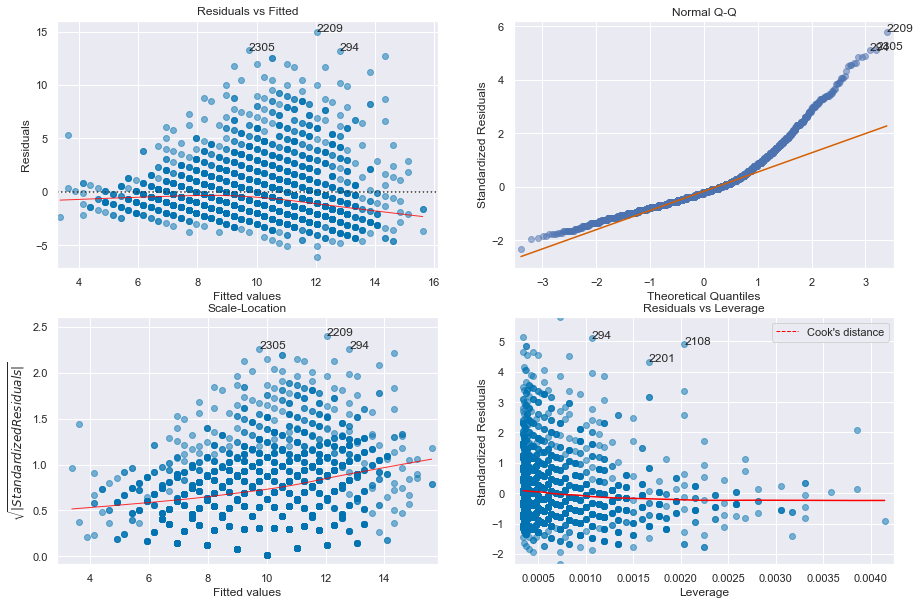

In [13]:
plot(model_simple1)

* The zero-mean noise assumption looks reasonable according to the first plot.
* The qq-plot reveals that the Gaussian assumption is not sastified. We observe indeed a significant deviation from the diagonal for extreme values on the right.
* We clearly observe heteroscedastic noise on the first and third plots.
* We do not observe outliers on the fourth plot. All points are within cook-distance boundaries.

It is clear that this model is not satisfying. We can attempt a transformation of the response variable to get a valid model.

##### Transforming the data

We suggest to use a simple log-transform of the response

In [14]:
# Feature engineering 
df_train.loc[:, 'logRings'] = np.log(df_train['Rings'])
df_test.loc[:, 'logRings'] = np.log(df_test['Rings'])

# Fitting the model with the transformed data
model_simple2 = smf.ols('logRings~Height', data=df_train).fit()
print(model_simple2.summary())

                            OLS Regression Results                            
Dep. Variable:               logRings   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     2515.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:58:31   Log-Likelihood:                 86.026
No. Observations:                2923   AIC:                            -168.1
Df Residuals:                    2921   BIC:                            -156.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4630      0.016     90.219      0.0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


##### Diagnostics with transformed data

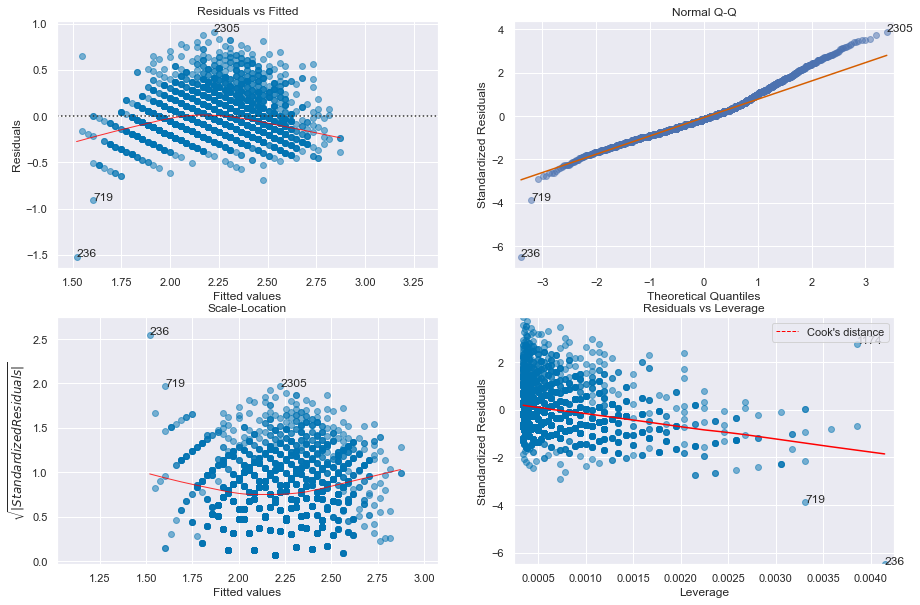

In [15]:
plot(model_simple2)

* The first plot reveals some sort of parabolic residues but nothing too egregious.
* We can now accept the Gaussianity assumption thanks to the qq-plot.
* The third plot shows some improvement regarding homoscedasticity. We could work with that.
* The fourth plot did not reveal any outlier.

The model is valid. Moreover, the log-transform of the response did improve the diagnostic plots.

### Question 7: Interpret your final parameter estimates in context. Provide 95% confidence intervals for $\beta_0$ and $\beta_1$. Interpret in context of the problem.

In [16]:
model_simple2.params

Intercept    1.462996
Height       5.639737
dtype: float64

On average, we have that:

$$
log(\textit{Rings})=  \text{$1.46+5.64\textit{ Height}$ + $\xi$}
$$

We have a positive slope wich corresponds to a positive correlation between the Height and the actual number of Rings. A larger Height is thus indeed associated to an older age.

In [17]:
model_simple2.conf_int(alpha=0.05)

,0,1
Intercept,1.431200,1.494793
Height,5.419219,5.860255


* We are 95% confident that the true value of the intercept $\beta_0$ is in [1.43 , 1.49], and that of the slope $\beta_1$ is in [5.42 , 5.86]. Note that this interval does not contain 0.
* Both intervals are narrow. The range of the first one (0.06) and the second one (0.44) are very small, it shows that the estimations are precise.

### Question 8: Is there a statistically significant relationship between the height and the number of rings (and hence, the age) of abalones?

The slope $\beta_1$ (5.64) is strongly positive, which suggests that there is a statistically significant correlation between the Height and the Number of Rings.

The coefficient of determination $R^2$ (0.46) indicates that the Height is an important (but still not sufficient) predictor for the Age.

Overall, we see that there is still variance between the model and the data. We suggest a multiple linear regression model to incorporate additional predictors for a higher accuracy.

# Part 2: Multiple linear regression, ANOVA, ANCOVA

### Question 9: Consider now all variables. Look at the scatterplot of the data (seaborn:pairplot). Look for correlations between predictors. Select some additional variables to add to the simple linear model of Part II in order to better predict number of rings. Justify your choices (keep in mind that we want a practical method to predict number of rings). Perform a multiple linear regression. Check the validity of the model. If validity conditions are not met, transform some variables, add/delete some variables and recheck until you find an acceptable model.

Looking at the correlation matrix (Part 1: question 3), it might not be necessary to introduce all the weight variables as they are strongly correlated to each other. We choose to only add Whole_weight. Similarly, Length and Diameter are strongly correlated to Height, it might not be necessary to introduce them either.

Let's consider the variable Sex:

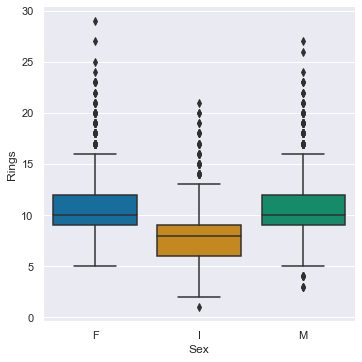

In [18]:
sns.catplot(y='Rings', x='Sex', data=df, kind='box')
plt.show()

We observe that there is no difference between Male and Female abalones in their number of Rings. However, there is a noticeable difference in the number of rings between infant and non infant. It might make sense to add the Infant variable to the model. (Infant variable was introduced in question 3, it takes the value I when the subject is an infant and NI otherwise).


We consider the following linear model :

$$
log(Y)=  \text{$\beta_0+\beta_1\textit{ Infant}+\beta_2\textit{ Height}+\beta_3\textit{ Whole_weight}$ + $\xi$}
$$

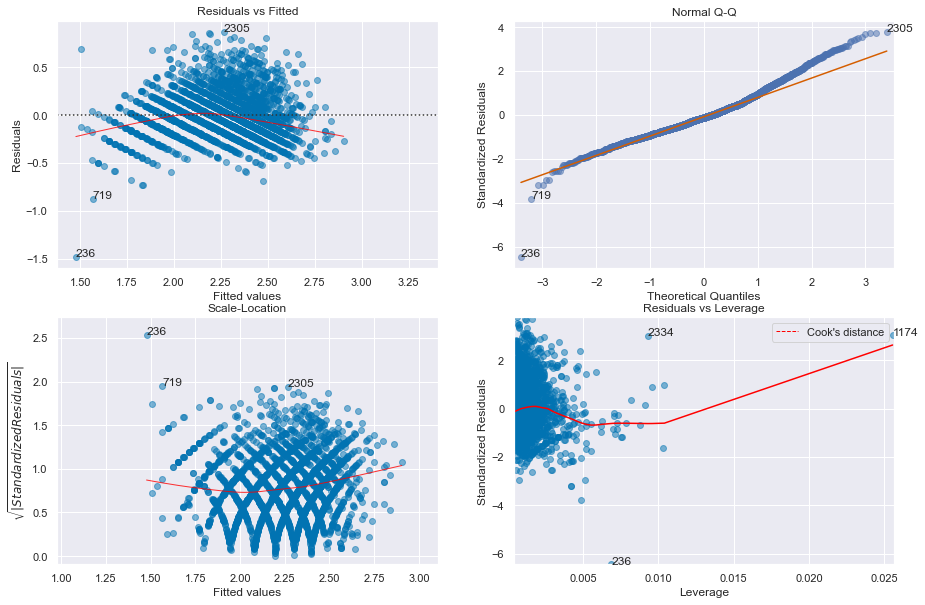

In [19]:
model_multi1 = smf.ols('logRings~Infant+Height+Whole_weight', data=df_train).fit()
plot(model_multi1)

* The normality assumption of residues as well as the homosciedasticity one holds. 
* We do not observe any influential outliers from the fourth plot. 

The model looks valid but the first plot shows that there is still some quadratic structure to catch. We suggest adding the square of Height.


Therefore, we consider now the model :

$$
log(Y)=  \text{$\beta_0+\beta_1\textit{ Infant}+\beta_2\textit{ Height}+\beta_3\textit{ Whole_weight}+\beta_4\textit{ } Height^2$ + $\xi$}
$$

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


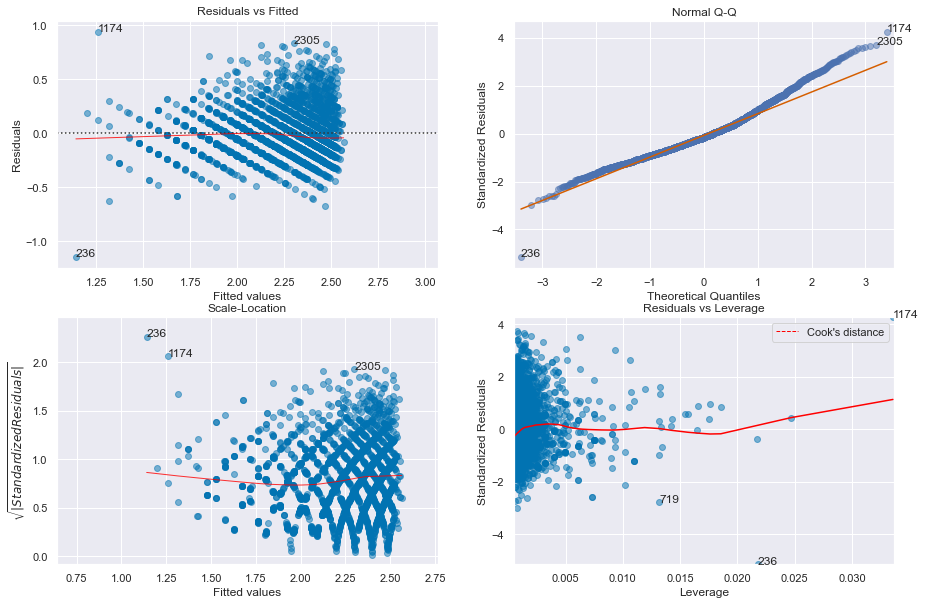

In [20]:
df_train.loc[:, 'Height_sqrd'] = np.square(df_train['Height'])
df_test.loc[:, 'Height_sqrd'] = np.square(df_test['Height'])
model_multi2 = smf.ols('logRings~Infant+Height+Whole_weight+Height_sqrd', data=df_train).fit()
plot(model_multi2)

* Now we can see that the model is more linear : we have improved the zero mean as well as the homoscedascity of the residuals.
* The qq-plot reveals a slightly worse deviation from gaussianity for extreme values on the right. But the model is still acceptable.
* We still don't observe any outliers in the cook's distance plot. 

### Question 10: Perform t-tests to check which variables have a significant impact on number of rings.

In [21]:
print(model_multi2.summary())

                            OLS Regression Results                            
Dep. Variable:               logRings   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     759.0
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:58:37   Log-Likelihood:                 220.60
No. Observations:                2923   AIC:                            -431.2
Df Residuals:                    2918   BIC:                            -401.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0178      0.039     26.364   

For each variable, we are testing whether or not it has a significant impact on Rings. We use 𝑡-tests, which are used to check the significance of individual regression coefficients in the multiple linear regression model. In the summary above, we can see for all variables, except Whole_weight, a very strong evidence in favor of the alternative hypothesis, considering that the p-values ($\approx$0) are way lower than 5%. We reject the null hypothesis for these variables and conclude that they have a significant impact. As for Whole_weight, its p-value (0.069) is high enough to not reject the null hypothesis, but it doesn't necessarily mean that we can accept it.

We suggest to replace Whole_weight by the sum of Shucked_weight and Shell_weight as the first one represents the weight of the meat without the shell and the second one represents the weight of the dried shell. We did not include Viscera_weight as it is already somehow included in the measurment of Shucked_weight.

In [22]:
model_multi3 = smf.ols('logRings~Infant+Height+Shucked_weight+Shell_weight+Height_sqrd', data=df_train).fit()
print(model_multi3.summary())

                            OLS Regression Results                            
Dep. Variable:               logRings   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     890.7
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:58:37   Log-Likelihood:                 533.08
No. Observations:                2923   AIC:                            -1054.
Df Residuals:                    2917   BIC:                            -1018.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0073      0.035     29.

* All the p-values are approximatively equal to 0, which means that all the variables that we chose for this model have a significant impact.
* Moreover, the $R^2$ score is quite substancial and seems acceptable for our regression.

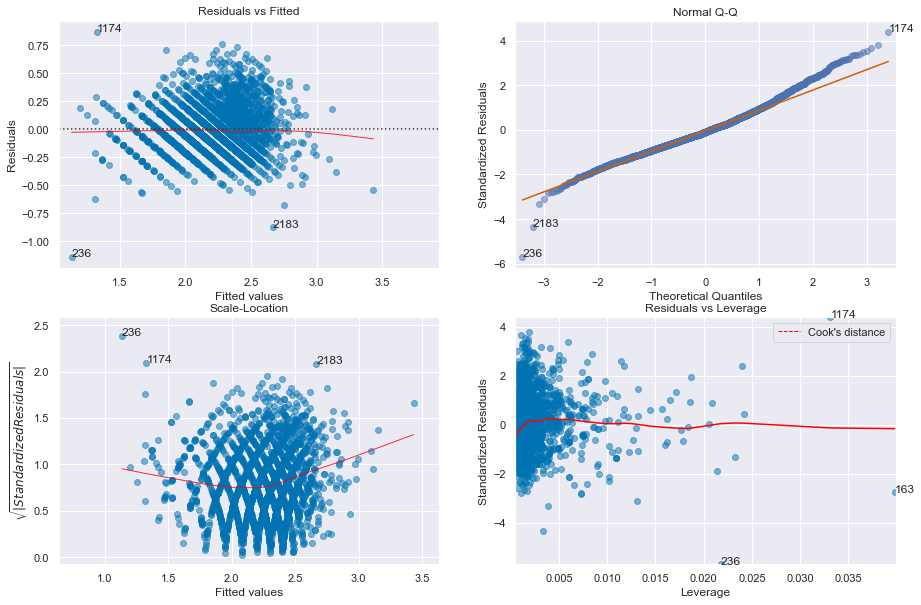

In [23]:
plot(model_multi3)

* The zero-mean noise assumption looks reasonable according to the first plot.
* We can accept the Gaussianity assumption thanks to the qq-plot.
* The third plot shows that homoscedasticity seems to hold more or less. We could work with that.
* The fourth plot did not reveal any outliers.

The model is valid.

### Question 11: Perform an ANOVA test to decide between the simple linear model and the multiple linear model.

In [24]:
# Deciding between the simple linear model of Part I and the multiple linear model of question 9
sm.stats.anova_lm(model_simple2, model_multi3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2921.0,161.358232,0.0,NaN,NaN,NaN
1,2917.0,118.835279,4.0,42.522953,260.948294,6.766455e-192


We are testing the hypothesis that all variables other than Height are uncorrelated with Rings, given the value of Height (Simple Linear Model). The ANOVA table shows that there is very strong evidence in favor of the alternative hypothesis considering that the p-value (6.77e-192) is way lower than 5%. We reject the null hypothesis and choose the Multiple Linear Model.

### Question 12: We want to determine whether the covariate sex has an impact on the number of rings? To this end, add the variable sex to the previous multiple linear model (if you did not already) and perform an ANCOVA analysis of the dataset.

ANCOVA is used to test the main interaction effects of categorical variables (Sex in our case) on a continuous dependent variable (Rings in our case), in the presence of other quantitative variables, which covary with the response variable.

In [25]:
numerical_columns = [c for c in df.columns
                     if df[c].dtype.kind in ["i", "f"]]
# We use the ancova function from the Pingouin package
ancova(data=df_train, dv='Rings', between='Sex', covar=numerical_columns[:-1])

,Source,SS,DF,F,p-unc,np2
0,Sex,309.122240,2,31.522045,2.858818e-14,0.021184
1,Length,5.762649,1,1.175266,2.784115e-01,0.000403
2,Diameter,59.239848,1,12.081700,5.166345e-04,0.004130
3,Height,482.612240,1,98.426595,7.732993e-23,0.032684
4,Whole_weight,531.412180,1,108.379123,6.045793e-25,0.035871
5,Shucked_weight,1939.013307,1,395.453040,1.282470e-82,0.119528
6,Viscera_weight,282.917497,1,57.699751,4.087768e-14,0.019423
7,Shell_weight,92.199431,1,18.803659,1.498057e-05,0.006414
8,Residual,14283.227577,2913,NaN,NaN,NaN


The ANCOVA test tells us that the predictor Sex does have an impact (p-value = 2.86e-14 << 5%, so we reject the null hypothesis). We find a significant difference in Rings between abalones from different genders, which concludes our ANCOVA analysis.

In [26]:
ancova(data=df_train, dv='Rings', between='Infant', covar=numerical_columns[:-1])

,Source,SS,DF,F,p-unc,np2
0,Infant,307.885775,1,62.808037,3.215016e-15,0.021099
1,Length,5.758421,1,1.174706,2.785261e-01,0.000403
2,Diameter,58.932395,1,12.022082,5.333509e-04,0.004109
3,Height,481.916140,1,98.309858,8.184502e-23,0.032636
4,Whole_weight,530.542320,1,108.229494,6.500079e-25,0.035811
5,Shucked_weight,1940.751988,1,395.909239,1.044512e-82,0.119613
6,Viscera_weight,283.775107,1,57.889513,3.718450e-14,0.019479
7,Shell_weight,92.484229,1,18.866584,1.449735e-05,0.006433
8,Residual,14284.464042,2914,NaN,NaN,NaN


We notice that the p-value (3.22e-15) and the Sum of Squares (308) are slightly lower for the covariate Infant than for the covariate Sex, which might indicate that it is more significant and which enforces our choice to use it instead of Sex for our multiple linear model.

# Part III: Model Selection and Prediction

### Question 13: Build an estimator of the generalization error of the simple linear model and the multiple linear model using the test set.

A generalization error could be measured by MSE. Indeed, as the model capacity increases, the bias decreases since the model fits the training dataset better. However, the variance increases, as the model becomes more complex to fit additional patterns of the dataset. We thus decided to use the MSE as an estimator of the generalization error for each of the two models.

In [27]:
# Defining the y_test for all the models
y_test = df_test['logRings']

# MSE for Simple Linear Regression 
X_test_simple = df_test['Height']

y_pred_simple = model_simple2.predict(X_test_simple)

mse_simple = metrics.mean_squared_error(y_test, y_pred_simple)

print(f'The MSE for the simple linear model is: {mse_simple:.3f}')

The MSE for the simple linear model is: 0.055


In [28]:
# MSE for Multiple Linear Regression
X_test_multi = df_test[['Infant', 'Height', 'Shucked_weight', 'Shell_weight', 'Height_sqrd']]

y_pred_multi = model_multi3.predict(X_test_multi)

mse_multi = metrics.mean_squared_error(y_test, y_pred_multi)

print(f'The MSE for the multiple linear model is: {mse_multi:.3f}')

The MSE for the multiple linear model is: 0.039


We conclude that the multi linear model has a better predictive accuracy than the simple linear model since it has a smaller MSE.

### Question 14: Build a model including all variables and maybe including some polynomials. Perform model selection using the BIC criterion. Compare the prediction error on the test set of the selected model to that of the ANOVA selected model of Part II.

#### Building a model that includes all variables

/Users/ayaerrajraji/Documents/Polytechnique/Regression/Projet Regression/diagnostic_plots.py:167: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
/Users/ayaerrajraji/Documents/Polytechnique/Regression/Projet Regression/diagnostic_plots.py:170: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
/Users/ayaerrajraji/Documents/Polytechnique/Regression/Projet Regression/diagnostic_plots.py:172: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: -np.sqrt((0.5 * p * (1 - x)) / x),
/Users/ayaerrajraji/Documents/Polytechnique/Regression/Projet Regression/diagnostic_plots.py:175: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: -np.sqrt((1 * p * (1 - x)) / x),


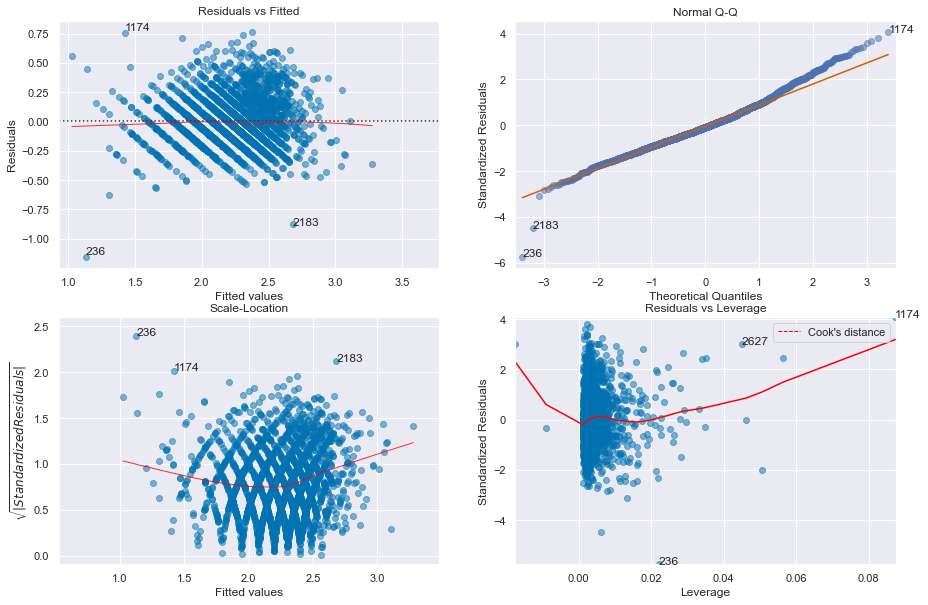

In [29]:
model_all = smf.ols('logRings~Sex+Length+Diameter+Height+Whole_weight+Shucked_weight+Viscera_weight+Shell_weight+Infant+Height_sqrd', data=df_train).fit()
plot(model_all)

* The zero-mean noise assumption looks reasonable according to the first plot.
* We can accept the Gaussianity assumption thanks to the qq-plot.
* The third plot shows that homoscedasticity seems to hold more or less.
* The fourth plot does not reveal any outliers.

The model seems to be valid.

#### Performing model selection using the BIC criterion

In [30]:
# Encoding the categorical features
encoder = OrdinalEncoder()
df_train.loc[:, ['Sex', 'Infant']] = encoder.fit_transform(df_train[['Sex', 'Infant']])
df_test.loc[:, ['Sex', 'Infant']] = encoder.fit_transform(df_test[['Sex', 'Infant']])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


To choose the best model according to the BIC criterion, we use the function exhaustivesearch_selectionmodel() provided in model_selection_python.py


This function selects a model by exhaustive search. Here, we have 10 candidates, so it is reasonable to do an exhaustive search (among the $2^{10}-1=1023$ possible models for the model selection). If we had a data set with much more candidate variables, we would have chosen another method (backward or forward search).

In [31]:
X_test_all = df_test[['Sex', 'Infant', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Height_sqrd']]

df_subsets = exhaustivesearch_selectionmodel(X_test_all, y_test, vmax=X_test_all.shape[1])

Features: 1023/1023

In [32]:
df_subsets.sort_values(by='BIC', ascending=False)

,Variables,R2,R2_adj,Cp,BIC,Number of variables (except intercept)
3,[Diameter],0.46648,0.466053,569.242,-772.315,1
36,"[Diameter, Shucked_weight]",0.513541,0.512762,410.858,-880.797,2
150,"[Diameter, Shucked_weight, Shell_weight]",0.584254,0.583254,171.869,-1070.32,3
378,"[Height, Shucked_weight, Shell_weight, Height_...",0.604614,0.603346,104.479,-1126.06,4
574,"[Infant, Height, Shucked_weight, Shell_weight,...",0.61755,0.616015,62.3947,-1160.57,5
815,"[Infant, Height, Whole_weight, Shucked_weight,...",0.626067,0.624265,35.3671,-1181.64,6
1022,"[Sex, Infant, Length, Diameter, Height, Whole_...",0.635858,0.632924,10,-1186.33,10
958,"[Infant, Height, Whole_weight, Shucked_weight,...",0.630418,0.628338,22.5401,-1189.16,7
1019,"[Sex, Infant, Diameter, Height, Whole_weight, ...",0.635751,0.633111,8.36651,-1193.09,9
1010,"[Infant, Diameter, Height, Whole_weight, Shuck...",0.635216,0.632868,8.18954,-1198.39,8


In [33]:
df_subsets.sort_values(by='BIC', ascending=False).iloc[-1,0]

['Infant',
 'Diameter',
 'Height',
 'Whole_weight',
 'Shucked_weight',
 'Viscera_weight',
 'Shell_weight',
 'Height_sqrd']

We can see that the model selected using this method has 8 variables: Infant, Diameter, Height, Whole_weight, Schucked_weight, Viscera_weight, Shell_weight, Height_sqrd.

Intuitively, we expected to get a model with only one measurement of type weight, since different measurements of the same physical feature of an abalone are likely to be strongly dependent and not all simultaneously necessary to predict its age.

#### Comparing the prediction error on the test set of the selected model to that of the ANOVA selected model of Part II

In [34]:
# MSE for the BIC selected model
model_bic = smf.ols('logRings~Infant+Diameter+Height+Whole_weight+Shucked_weight+Viscera_weight+Shell_weight+Height_sqrd', data=df_train).fit()

X_test_bic = df_test[['Infant', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Height_sqrd']]

y_pred_bic = model_bic.predict(X_test_bic)

mse_bic = metrics.mean_squared_error(y_test, y_pred_bic)

print(f'The MSE for the BIC selected model is: {mse_bic:.3f}')

The MSE for the BIC selected model is: 0.038


We can see that the MSE of the BIC selected model (0.038) is slightly smaller than the one of the ANOVA selected model (0.039). This indicates that the model that we built in part II is almost as performant as the BIC selected one.

### Question 15: Use the package scikit-learn to implement some ML predictors on the train set including all covariates. You can pick 3 methods among LASSO, Elastic Net, Random Forest, XGBoost, extra trees regression, etc,. . . Compare their prediction performance to the manually built model.

In [35]:
# Defining the train and test tests with the inital features to implement the ML predictors
X_train = df_train[['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']]
y_train = df_train['Rings']
X_test = df_test[['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']]
y_test = df_test['Rings']

#### Lasso

In [36]:
# Standardizing features by removing the mean and scaling to unit variance
scaler = StandardScaler() 
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train))
X_test_sc = pd.DataFrame(scaler.fit_transform(X_test))

In [37]:
from sklearn import linear_model

regressor = linear_model.Lasso(alpha=0.01)
regressor.fit(X_train_sc, y_train)
y_pred = regressor.predict(X_test_sc)

print('The corresponding RMSE is: %.2f'
      % metrics.mean_squared_error(y_test, y_pred, squared=False))
print('The corresponding R2 score is: %.2f'
      % metrics.r2_score(y_test, y_pred))

The corresponding RMSE is: 2.20
The corresponding R2 score is: 0.54


#### Random Forest 

In [38]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('The corresponding RMSE is: %.2f'
      % metrics.mean_squared_error(y_test, y_pred, squared=False))
print('The corresponding R2 score is: %.2f'
      % metrics.r2_score(y_test, y_pred))

The corresponding RMSE is: 1.72
The corresponding R2 score is: 0.71


#### XGBoost

In [39]:
from xgboost import XGBRegressor

regressor = XGBRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('The corresponding RMSE is: %.2f'
      % metrics.mean_squared_error(y_test, y_pred, squared=False))
print('The corresponding R2 score is: %.2f'
      % metrics.r2_score(y_test, y_pred))

The corresponding RMSE is: 1.81
The corresponding R2 score is: 0.69


Scikit-Learn's Random Forest Regressor has the lowest RMSE and highest $R^2$ score, which means that it performed better than the two other ML predictors.

It also performed better than our manually built model since it has a higher $R^2$ score.